# Barycentric formula

When we want to approximate a function on a bounded interval without the benefit of periodicity, the game changes. Attempting to extend the function periodically does permit using Fourier methods, but they will be subject to the Gibbs phenomenon and converge poorly, if at all.

It seems more reasonable instead to interpolate by a polynomial, which makes no assumption about periodicity. It turns out that there are issues of both selecting a well-conditioned polynomial and of evaluating it stably. We begin with the second of these issues.

## Derivation

Recall the Lagrange form of the interpolating polynomial on the nodes $x_0,x_1,\dots,x_n$: 

$$
p(x) = \sum_{i=0}^n y_i \ell_i(x), 
$$

where 

$$
\ell_i(x) = \frac{\Phi(x)}{\Phi'(x_i)(x-x_i)}, \qquad \Phi(x) = \prod_{i=0}^n (x-x_i).
$$

We note that 

$$
p(x) & = \Phi(x) \sum_{i=0}^n \frac{y_i}{\Phi'(x_i)(x-x_i)} \\  
& = \Phi(x) \sum_{i=0}^n \frac{y_iw_i}{x-x_i},
$$

where $w_i=1/\Phi'(x_i)$. The constant function 1 is interpolated when all $y_i=1$, so

$$
1 = \Phi(x) \sum_{i=0}^n \frac{w_i}{x-x_i},
$$

which allows us to eliminate $\Phi$ and write

$$
p(x) = \frac{\displaystyle \sum_{i=0}^n \frac{y_iw_i}{x-x_i}}{\displaystyle \sum_{i=0}^n \frac{w_i}{x-x_i}}. 
$$

This is known as the **barycentric formula** (historically, the *second* barycentric formula). It's an odd-looking way to write a polynomial! But it's been proved to be numerically stable, and it's efficient, as well. 


## Usage 

The **barycentric weights** $w_i$ are known explicitly in a few cases. For equally spaced nodes in $[-1,1]$, for example,

$$
w_j = (-1)^j \binom{n}{j}, \qquad j=0,\ldots,n. 
$$

If the weights are not known explicitly for a node set, then $O(n^2)$ operations are needed to compute them. Note that a uniform scaling of the weights does not affect the formula, so in practical implementations they are scaled to avoid overflow or underflow in the products.

Once the weights have been found, evaluating $p$ at one point takes only $O(n)$ flops, regardless of the interpolated values $y_i$.

In [1]:
using Sugar, SpectralMethodsTrefethen
Sugar.get_source(first(methods(polyinterp))) |> last |> print
println()

function polyinterp(x,y)
    C = 4/(maximum(x) - minimum(x))
    weight(i) = 1 / prod(C*(x[i]-x[j]) for j in eachindex(x) if j != i) 
    w = weight.(eachindex(x))
    return function(t)
        denom = numer = 0
        for i in eachindex(x)
            if t==x[i]
                return y[i]
            else
                s = w[i] / (t-x[i])
                denom += s 
                numer = muladd(y[i],s,numer)
            end
        end
        return numer / denom
    end
end


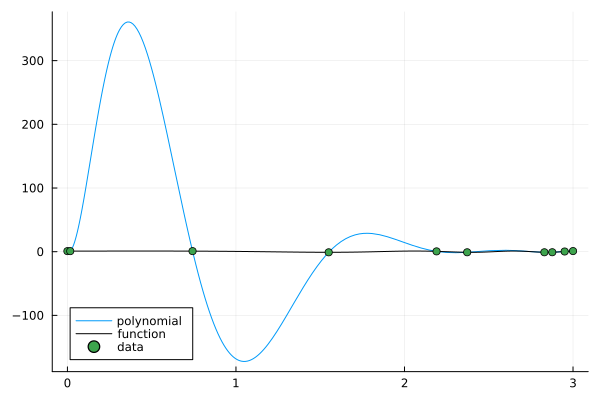

In [2]:
using Plots

f = x -> sin(exp(x))
x = [0; 3*rand(8); 3]
y = f.(x)
p = polyinterp(x, y)
plot(p,0,3,label="polynomial",legend=:bottomleft)
plot!(f,0,3,color=:black,label="function")
scatter!(x,y,markersize=4,label="data")

## Runge phenomenon

The barycentric formula gives us a stable way to evaluate an interpolating polynomial. However, these polynomials don't always behave as we would like, particularly on equispaced points.

The Hermite error formula for polynomial interpolation includes a factor $\Phi(x)$. On equispaced node sets of length $n+1$, this behaves poorly across the interpolating interval as $n\to \infty$.

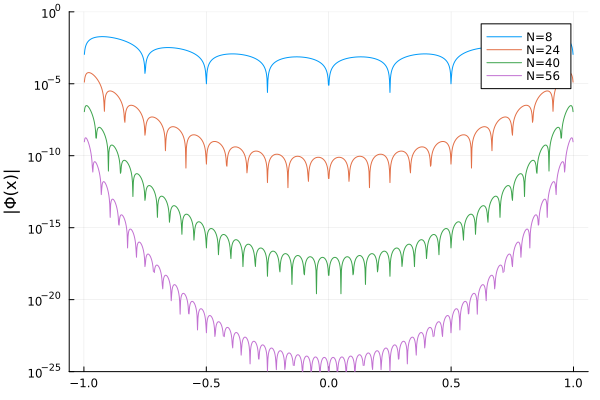

In [3]:
plt = plot(yaxis=(:log,[1e-25,1],"|Φ(x)|"))
t = range(-1,1,1100)
for n in 8:16:56
    x = range(-1,1,n+1)
    Phi = t -> prod(t-x for x in x)
    plot!(t,abs.(Phi.(t)),label="N=$n")
end
plt

In the above, it's clear that $\norm{\Phi}_\infty \to 0$ as $N \to \infty$. However, there is a rapidly widening gap between $|\Phi|$ near the boundary and near the center. In the next section, we will see that this gap is of size $2^N$. As it grows, it becomes impossible for machine precision to resolve all of the scales. For $O(1)$ data, when the error in the middle is $O(\epsilon_{\text{mach}})$, the error at the boundaries increases beyond $O(1)$ in order to maintain the gap. 

To counteract this effect, we can use interpolation nodes that are more crowded toward the boundaries. Our prime example is the **Chebyshev 2nd-kind points**,

$$
x_j = \cos\left( \frac{j\pi}{N} \right), \qquad j = 0,\ldots,N. 
$$

These points are the abscissas of equally spaced points on the unit circle:

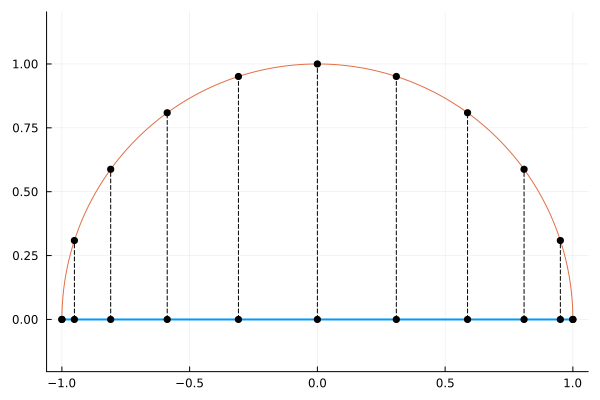

In [4]:
plot([-1,1],[0,0],l=2,aspect_ratio=1,legend=false)
plot!(cos,sin,0,π,l=1)
N = 10
θ = (0:N)*π/N
z = cis.(θ)
x,y = real(z),imag(z)
plot!([x x]',[zero(x) y]',l=(:dash,:black),m=(4,:black))

As we will show in the next section, these points produce a $|\Phi|$ that is nearly flat across the interval:

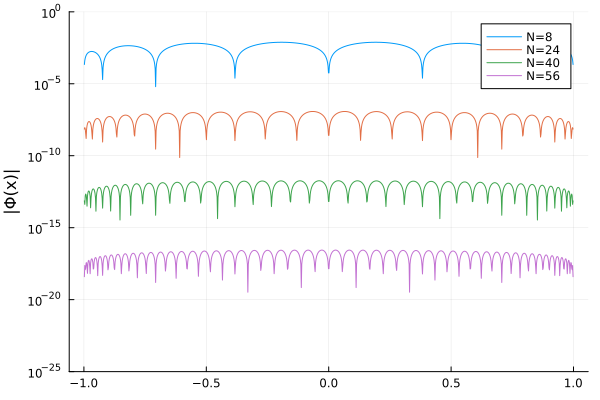

In [5]:
plt = plot(yaxis=(:log,[1e-25,1],"|Φ(x)|"))
t = range(-1,1,1100)
for N in 8:16:56
    x = @. cos((0:N)*π/N)
    Phi = t -> prod(t-x for x in x)
    plot!(t,abs.(Phi.(t)),label="N=$N")
end
plt

It's also worth noting that the barycentric weights for the 2nd-kind Chebyshev points are simply

$$
w_j = (-1)^j \cdot \begin{cases} \tfrac{1}{2}, & j=0 \text{ or } j=N, \\ 1, & 1 \le j \le N-1. \end{cases} 
$$

The poor conditioning of equispaced points in polynomial interpolation is known as the **Runge phenomenon**. It's typically demonstrated on a very innocuous-looking function, $1/(1 + 16x^2)$:

function p9(N = 16)
    xx = -1.01:0.005:1.01
    fig = Figure()
    labels = ["equispaced points", "Chebyshev points"]
    points = [-1 .+ 2 * (0:N) / N, cospi.((0:N) / N)]
    for (i,(s,x)) in enumerate(zip(labels,points))
        ax = Axis(fig[i, 1], title=s)
        u = @. 1 / (1 + 16 * x^2)
        uu = @. 1 / (1 + 16 * xx^2)
        p = polyinterp(x, u)              # interpolation
        pp = p.(xx)                       # evaluation of interpolant
        lines!(xx, pp)
        scatter!(x, u)
        limits!(-1.05, 1.05, -1, 1.5)
        error = norm(uu - pp, Inf)
        text!(-0.5, -0.5, text=f"max error = {error:.5g}")
    end
    return fig
end


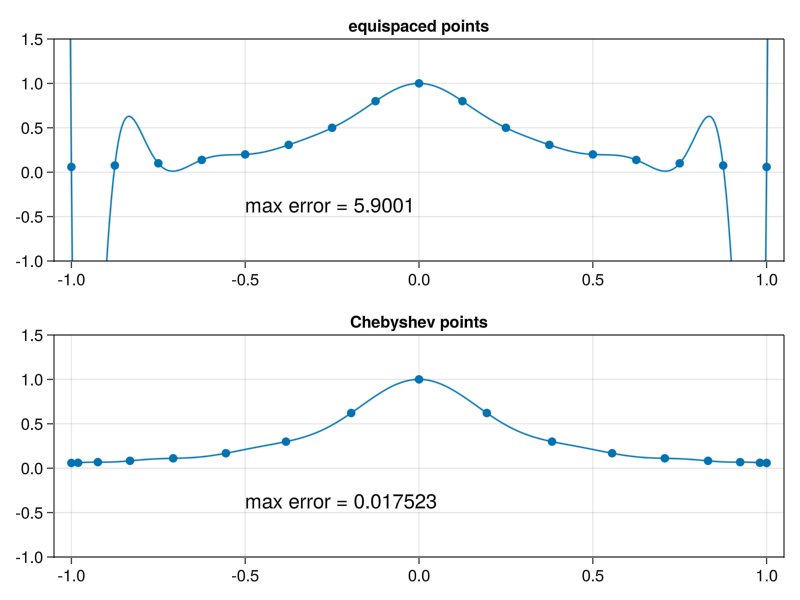

In [6]:
Sugar.get_source(first(methods(p9))) |> last |> print
println()
p9()